In [2]:

# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd
from matplotlib.patches import Patch
import math 

Energy cutoffs for various configs of Starship
-Sun reference frame 11.1k -> 7.9k Earth frame (Saturn Transit)
-Sun reference frame 9.2k  -> 6.6k Earth frame (Jupiter transit)
-Sun reference frame 5.2k  -> 4.4k Earth frame (Mars transit)

(1826, 365)
(2, 1826, 365)


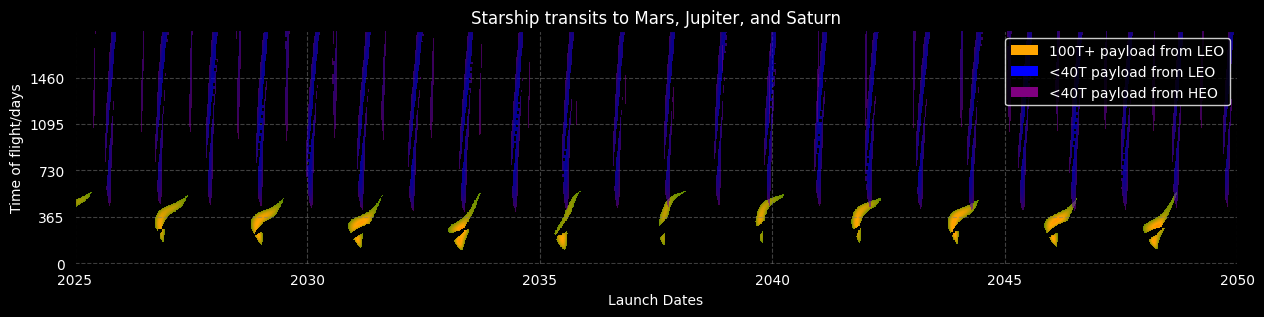

In [3]:
dvs_venus = pd.read_csv('venus_dvs.csv', header=None).values
dvs_mars = pd.read_csv('mars_dvs.csv', header=None).values
dvs_jupiter = pd.read_csv('jupiter_dvs.csv', header=None).values
dvs_saturn = pd.read_csv('saturn_dvs.csv', header=None).values
# test = np.array([[2,3],[3,4]])
print(dvs_mars.shape)

#tof in units of 5 days, up from 0.25 yr to 5 yr

fig, ax = plt.subplots(figsize=(15, 12))
# dv_stack = np.stack((dvs_mars,dvs_jupiter), axis=1)  # shape (3, Ny, Nx)

dv_stack = np.stack([dvs_mars, dvs_jupiter], axis=0)  # shape (3, Ny, Nx)
print(dv_stack.shape)

# mask_nan = np.isnan(dv_stack)
venus_mask_val= np.ma.masked_where(dvs_venus>5000,dvs_venus)
mars_mask_val= np.ma.masked_where(dvs_mars>5000,dvs_mars)
jupiter_mask_val= np.ma.masked_where(dvs_jupiter>12000,dvs_jupiter)
saturn_mask_val= np.ma.masked_where(dvs_saturn>12000,dvs_saturn)

# Large filler so masked entries never win
# dv_filled = np.where(mask_nan, np.inf, dv_stack)




def step_cmap_rygk(cut1=4000, cut2=6000, cut3=8000,
                   labels=("red zone","yellow zone","green zone","black zone")):
    """
    Returns a step colormap & norm with 4 bins:
      (-inf, cut1] -> red
      (cut1, cut2] -> yellow
      (cut2, cut3] -> green
      (cut3, +inf) -> black

    labels: 4 strings for the colorbar tick labels (one per bin).
    """
    bounds = [-np.inf, float(cut1), float(cut2), float(cut3), np.inf]
    colors = ["red", "yellow", "green", "black"]
    cmap = ListedColormap(colors, name="rygk_steps")
    norm = BoundaryNorm(bounds, cmap.N, clip=False)
    return cmap, norm, bounds, list(labels)


# # Build the step map (change the labels to your words)
# cmap, norm, bounds, words = step_cmap_rygk(
#     cut1=4000, cut2=6000, cut3=8000,
#     labels=("sub-threshold", "nominal", "high", "saturated")
# )
# cmap = colors.LinearSegmentedColormap.from_list("red_to_orange_to_green_to_blue_to_purple_to_black", ["red","orange","green", "blue","purple","black"])
cmap = colors.LinearSegmentedColormap.from_list("red_to_orange_to_green_to_blue_to_purple_to_black", ["red","orange","green", "blue","purple","black"])



cax = ax.imshow(mars_mask_val.T, cmap=cmap, origin="lower", vmin=0, vmax=15000)
cax2 = ax.imshow(jupiter_mask_val.T, cmap=cmap, origin="lower", vmin=0, vmax=15000, alpha=0.6, zorder = 2)
cax3 = ax.imshow(saturn_mask_val.T, cmap=cmap, origin="lower", vmin=0, vmax=15000, alpha=0.6, zorder = 3)
# cax3 = ax.imshow(venus_mask_val.T, cmap='plasma', origin="lower", vmin=0, vmax=15000, alpha=0.6, zorder = 3)

# fig.colorbar(cax, ax=ax, label="Sun Frame DV", shrink=0.4)


def format_same_precision(x, *, offset=1, min_sig=1, frac_sig=1):
    """
    Round x so that integers with N digits get max(min_sig, N - offset) significant figures.
    - offset=1 → 4-digit→3sf, 3-digit→2sf, 2-digit→1sf, 1-digit→1sf
    - frac_sig: significant figures for |x| < 1
    - min_sig: floor on significant figures for any value
    Returns a plain string (no scientific notation), with trailing zeros stripped.
    """
    if x == 0 or not math.isfinite(x):
        return str(x)

    ax = abs(x)
    k = math.floor(math.log10(ax))          # order (…,-2,-1,0,1,…)

    if ax < 1:
        s = max(min_sig, frac_sig)          # sig figs for fractions
    else:
        n_int_digits = k + 1                # digits to left of decimal
        s = max(min_sig, n_int_digits - offset)

    # Convert desired sig figs to decimal places for round()
    ndigits = s - 1 - k
    y = round(x, ndigits)

    out = f"{y:f}"                          # fixed-point format
    if "." in out:
        out = out.rstrip("0").rstrip(".")
    return out

x_ticks = np.linspace(0,1826,6)
x_labels=[f'20{25+x*5/365.25:1.0f}' for x in x_ticks]

y_ticks = np.arange(0,365,365/5)
y_labels=[f'{y*5:1.0f}' for y in y_ticks]

ax.set_xlabel("Launch Dates", color = 'white')
ax.set_ylabel("Time of flight/days", color = 'white')
ax.set_title("Starship transits to Mars, Jupiter, and Saturn", color = 'white')
ax.set_facecolor('black')
ax.grid(True, color='gray', linestyle='--', alpha=0.5)
fig.patch.set_facecolor('black')
ax.set_xticks(x_ticks, labels=x_labels, color = 'white')
ax.set_yticks(y_ticks, labels=y_labels, color = 'white')

# plt.rcParams.update({
#     'figure.facecolor': '#0A0A0C',
#     'axes.facecolor':   '#0A0A0C',
#     'axes.edgecolor':   '#EEEEEE',
#     'axes.labelcolor':  '#EEEEEE',
#     'text.color':       '#EEEEEE',
#     'xtick.color':      '#CCCCCC',
#     'ytick.color':      '#CCCCCC',
#     'grid.color':       '#444444',
#     'font.family':      'monospace',
#     'axes.titlepad':    15,
# })


legend_elements = [
                   Patch(facecolor='orange', 
                         label='100T+ payload from LEO'),
                   Patch(facecolor='blue', 
                         label='<40T payload from LEO'),
                   Patch(facecolor='purple', 
                         label='<40T payload from HEO'),]
plt.legend(handles=legend_elements, loc='best', facecolor='black', edgecolor='white', labelcolor='white')

plt.show()
